In [2]:
import sys, os, time, shutil
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
# %load_ext autoreload
# %autoreload 2
# %pdb
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

import gym
import inspect
import numpy as np
import pickle

#%matplotlib tk
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train as trn
#from foundation.util import replicate, Cloner

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
# mpl.rc('image', cmap='gray')

# import gpumap
# import umap, shap
# import umap.plot

from sklearn.decomposition import PCA
import sklearn.datasets

# import gpumap

%matplotlib notebook

import project as proj
# import pointnets as ptn

np.set_printoptions(linewidth=120)

In [3]:
# dataset = trn.get_dataset('3dshapes', train=None, labeled=True, device='cpu')
# len(dataset)

In [4]:
M = trn.Run_Manager() # can pass arg with path
M.filter(lambda r: '3ds' in r.name and 't3ds' not in r.name)
M.filter(lambda r: not sum(x in r.name for x in {'12h', '6h', '4h','pvae'}))
M.filter(lambda r: sum(x in r.name for x in {'12b1'}))
# M.filter(lambda r: sum(x in r.name for x in {'conv'}))
pass

Found 355 runs
Auto parsing failed with: test-cmd_200517-145235
Auto parsing failed with: test-cmd_200517-153056
Auto parsing failed with: test-cmd_200517-164029
Auto parsing failed with: test-cmd_200517-164335
Auto parsing failed with: test-cmd_200517-164456
Auto parsing failed with: test-cmd_200517-170332
Auto parsing failed with: test-cmd_200517-170424
Auto parsing failed with: test-cmd_200517-170453


In [5]:
M.show()

  0) 3ds-ae-12b1-12attn_0000-6334436-03_200508-001046
  1) 3ds-ae-12b1-conv_0005-6337809-01_200509-120419
  2) 3ds-ae-12b1-dbl_0005-6337809-02_200509-120410
  3) 3ds-ae-12b1-dbl_0052-6286534-01_200429-031808
  4) 3ds-ae-12b1-dislib_0007-6337835-00_200509-125920
  5) 3ds-ae-12b1_0006-6241674-05_200414-020822
  6) 3ds-ae-12b1_0007-6241675-00_200414-020856
  7) 3ds-ae-12b1_0007-6241675-01_200414-020851
  8) 3ds-ae-12b1_0015-6243020-00_200414-174614
  9) 3ds-ae-12b1_0015-6243020-01_200414-174746
 10) 3ds-ae-12b1_0052-6286534-00_200429-030431
 11) 3ds-wae-12b1_0006-6241674-04_200414-020822


In [7]:
run = M[1]
run.name

'3ds-ae-12b1-conv_0005-6337809-01_200509-120419'

In [6]:
run.load_into('results.pth.tar')

In [18]:
print(run.results.keys())
print(run.results['out'].keys())

dict_keys(['out', 'stats', 'stats_num', 'rec_fid_stats', 'rec_fid', 'hyb_fid_stats', 'hyb_fid'])
odict_keys(['original', 'latent', 'reconstruction', 'rec_loss', 'loss', 'diffs'])


In [8]:
run.load_config()

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


3ds-ae-conv_0002-6337051-00_200508-232722 has no base


In [14]:
A = trn.get_config()
A.din = (3, 64, 64)
A.dout = A.din
model, = trn.load(run.name, config=A, get_data=None, update_config=True) # for loading only the model
print(model)

load successful
Loaded C:\Users\anwan\Documents\workspace\trained_nets\3ds-ae-conv_0002-6337051-00_200508-232722\best.pth.tar
Set dataroot to: C:\Users\anwan\Documents\workspace\local_data
Model-type: ae
  Creating encoder (type=conv)
    in_shape --> din: (3, 64, 64) (in parent)
    latent_dim: 12 (in parent)
    feature_dim: None (by default)
    nonlin: elu (in parent)
    output_nonlin: None (by default)
    residual: False (by default)
      channels (type=list): 
      [0]: 32
      [1]: 32
      [2]: 64
      [3]: 64
      [4]: 128
    kernels: 3
    strides: 2
    factors: 1
    down: max
    norm: group (in parent)
    output_norm: None (by default)
      fc_hidden (type=list): 
      [0]: 256
      [1]: 128
  Creating decoder (type=deconv)
    out_shape --> dout: (3, 64, 64) (in parent)
    latent_dim: 12 (in parent)
    nonlin: elu (in parent)
    output_nonlin: sigmoid
      channels (type=list): 
      [0]: 128
      [1]: 64
      [2]: 64
      [3]: 32
      [4]: 32
    ke

In [19]:
X = run.results['out']['original']
X.shape

torch.Size([128, 3, 64, 64])

In [23]:
with torch.no_grad():
    raw_Q = model.encode(X)
    if isinstance(raw_Q, distrib.Distribution):
        Q = raw_Q.mean
    else:
        Q = raw_Q
    rec = model.decode(raw_Q)
Q.shape, rec.shape

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


(torch.Size([128, 12]), torch.Size([128, 3, 64, 64]))

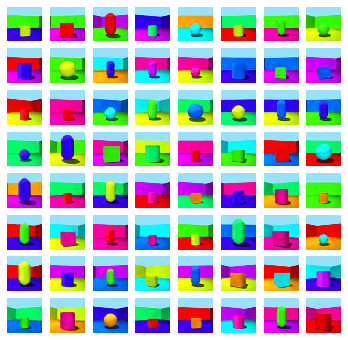

In [24]:
util.show_imgs(rec[:64])
pass

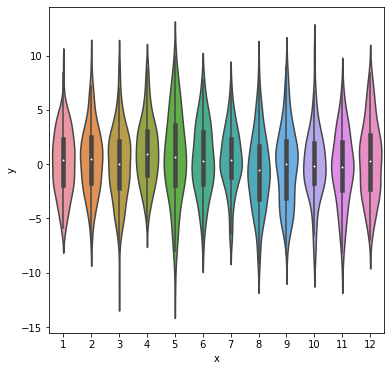

In [26]:
util.plot_distribs(Q)
pass